##### Import & Seed:

In [1]:
# Import:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) # include parent directory in the path
from toolbox.experiment import Experiment
from toolbox.SINDy import SINDy
from toolbox.symbolic_SINDy import symbolic_SINDy
from toolbox.cusum import CUSUM
from toolbox.auxiliary_functions import set_param_freq
from data import SINDy_data, equations

# Seed:
np.random.seed(999)

### Online-Symbolic-SINDy:

In [2]:
# Select ODE:
ode_name = 'OscillatingSelkovODE_d'
ode_param = '0.8,0.1'
freq = 10
ode_param, freq = set_param_freq(ode_param, freq)
ode = equations.get_ode(ode_name, ode_param)

# Parameters:
freq_SR = 20
n_sample = 50 
noise_ratio = 0.01
seed = 100 
n_seed = 1 
dt = 1 / freq
dim_x = 3
dim_k = 0
SW_length = 15 # SINDy sliding window length
SW_length_SR = 10 # SR sliding window length
H = 70 # length of the experiment
lazy = False # if True, we do not recompute the building blocks with SR
symbolic = True # if True, SR call is allowed, otw. simple SINDy is used throughout the whole experiment

# CUSUM parameters:
N = 10 # 10
eps = 0.01 
threshold = 0.3 


In [4]:
# Generate data: (7m)
X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k, 0, H)
print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

# Save data:
file_path = 'saved/data/oscillating_selkov_data.pkl'
os.makedirs(os.path.dirname(file_path), exist_ok=True)
with open(file_path, 'wb') as f:
    dill.dump((X_list, dX_list, param_list, feature_names), f)

(50, 700, 3) (50, 700, 3) (0,)
['X0', 'X1', 'X2']


In [3]:
# Load data:
file_path = 'saved/data/oscillating_selkov_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

In [4]:
# Initialize experiment and model discovery methods:
exp = Experiment(ode, ode_param, freq_SR, n_sample, noise_ratio, seed, n_seed, dt, dim_x, dim_k, SW_length, SW_length_SR, H, lazy, symbolic)

cusum = CUSUM(N, eps, threshold)

SINDy_method = SINDy(degree=3, include_bias=True, threshold=0.08)

SR_method = 'SR-T' # symbolic regression method chosen 
x_id = 0  # equation to be identified by SR 
symbolic_SINDy_method = symbolic_SINDy(SR_method, x_id=0, degree=3)

In [5]:
# Run the experiment:

while exp.T <= exp.H:

    print(f't: {exp.T}')

    # update time-window:
    X_list_t = [x[(exp.T0*freq):(exp.T*freq)] for x in X_list]
    dX_list_t = [dx[(exp.T0*freq):(exp.T*freq)] for dx in dX_list]  

    exp.step_forward(SINDy_method, symbolic_SINDy_method, cusum, X_list_t, dX_list_t, param_list, feature_names)

    # building block search time: 3m 15s
    # total time: 6m 20s

t: 15
SINDy model:
(X0)' = 0.697 1 + 0.247 X1 + -0.279 X0 X1 + -0.122 X1^2 + -0.843 X0 X1^2
(X1)' = 0.100 X0 + -0.994 X1 + 0.994 X0 X1^2
(X2)' = 1.000 1
Model complexity:  9
Lasso penalty:  5.276726801055558
RMSE:  0.01925851724024539

t: 16
RMSE:  0.019097999367173026

t: 17
RMSE:  0.02319461281982089

t: 18
RMSE:  0.02252102715291517

t: 19
RMSE:  0.02198505539442873

t: 20
RMSE:  0.019629748108997754

t: 21
RMSE:  0.02491342557504512

t: 22
RMSE:  0.025506623367343894

t: 23
RMSE:  0.024275194310096483

t: 24
RMSE:  0.024038463954291732

t: 25
RMSE:  0.022410274226055613

t: 26
RMSE:  0.022781007737118057

t: 27
RMSE:  0.020898447742655993

t: 28
RMSE:  0.02266806324779916

t: 29
RMSE:  0.022544718444993273

t: 30
RMSE:  0.024642286112912266

t: 31
RMSE:  0.03670991117645447

t: 32
RMSE:  0.04226852517355327

t: 33
RMSE:  0.050649719052013854

t: 34
RMSE:  0.059835311505776534

t: 35
RMSE:  0.06353972552095026

t: 36
RMSE:  0.08023521481728861

t: 37
RMSE:  0.08613706563468514

t: 3

/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     4.23          211.354        7         0.231004         0.238234      1.32m
   2     3.74          1568.51        7          0.22552         0.224913     55.73s
   3     4.71          76469.3       16         0.216507         0.222766     38.11s


/Users/grgromano/Documents/polimi/thesis/repos/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   4     7.22          47.1136       18         0.181364         0.188523     20.65s
   5     7.35          54.7141       18         0.181608         0.183287      0.00s

SR-T model:  sin(-C*X2 + C + 2*X2**C)

building blocks:
-sin(3.2410061383495*X2 - 0.17461618862005224)
sin(3.1394689809108645*X2)
-sin(3.2410061383495*X2 - 0.20225388594721674)
-sin(3.2410061383495*X2 - 0.2648142106347563)
-sin(3.2410061383495*X2 - 0.16215838256749215)
-3.1394689809108645*X2 + X2**1.8842541798778392 + X2**2.182075682230325 + 0.8305521946504155
 
number of building blocks:  6
 


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all 

No model update, all smart-SINDy models are too complex
RMSE:  0.16381468012179592

t: 42


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all 

No model update, all smart-SINDy models are too complex
RMSE:  0.20784296481590148

t: 43


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all 

No model update, all smart-SINDy models are too complex
RMSE:  0.17063116095320388

t: 44


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(


No model update, all smart-SINDy models are too complex
RMSE:  0.1956903663167607

t: 45


/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(
/Users/grgromano/miniconda3/envs/smart_SINDy/lib/python3.12/site-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.09) and eliminated all coefficients
  warnings.warn(



Best building block:
['sin(3.1394689809108645*X2)']

smart-SINDy model:
(X0)' = 0.545 1 + 0.703 X0 + 0.473 X1 + -0.452 X0^2 + -1.113 X0 X1 + 0.602 X0^2 X1 + -1.102 X0 X1^2 + 0.948 sin(3.1394689809108645*X2)
(X1)' = -0.995 X1 + 0.250 X0 X1 + 0.844 X0 X1^2
(X2)' = 1.000 1
Model complexity:  12
Lasso penalty:  9.026817598182472
RMSE:  0.025334616631463074

t: 46
RMSE:  0.025297684528275532

t: 47
RMSE:  0.0277866125729141

t: 48
RMSE:  0.018560708852408066

t: 49
RMSE:  0.029773168283352514

t: 50
RMSE:  0.027760868968775422

t: 51
RMSE:  0.02681537253708143

t: 52
RMSE:  0.03264560079845936

t: 53
RMSE:  0.02113336285130839

t: 54
RMSE:  0.02231195133032556

t: 55
RMSE:  0.027993954809974415

t: 56
RMSE:  0.017110135867426823

t: 57
RMSE:  0.02916090347251249

t: 58
RMSE:  0.028674613777509177

t: 59
RMSE:  0.024194311766615552

t: 60
RMSE:  0.02835859817763784

t: 61
RMSE:  0.021645249995882396

t: 62
RMSE:  0.01958561330911069

t: 63
RMSE:  0.028496408268896538

t: 64
RMSE:  0.0189694

plotting
(450,)
(450,)
(600,)
(600,)
plotting
(450,)
(450,)
(600,)
(600,)


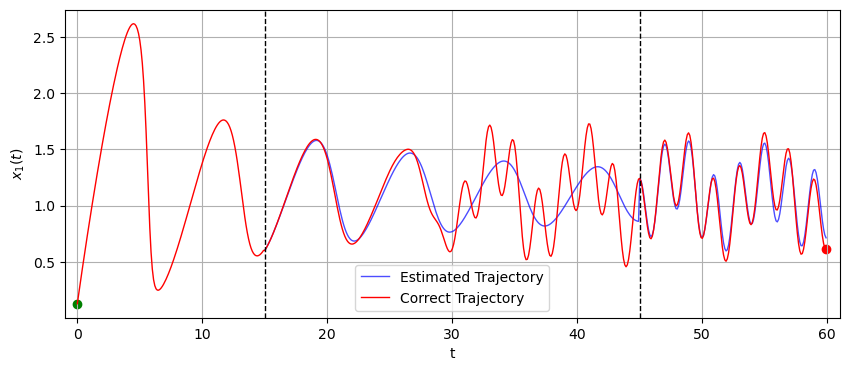

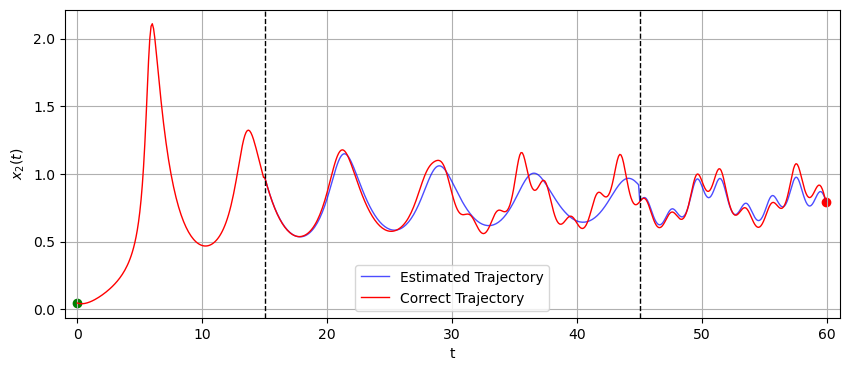

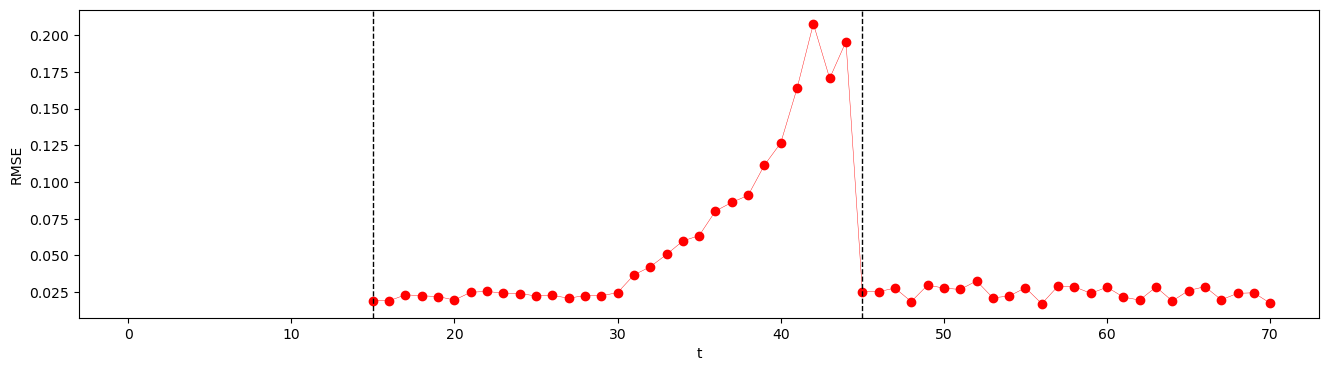

In [6]:
exp.plot()
exp.plot(x_id=1)
exp.plot_RMSE()

Ho esteso SINDy in maniera da svolgere una task di Online Model Discovery. Il metodo parte utilizzando la versione standard di SINDy e monitora il modello identificato inizialmente, testandolo sui dati che mano a mano giungono dal fenomeno. Tramite un algoritmo di change-point detection (CUSUM) il metodo rileva eventuali cambiamenti nel fenomeno sottostante. Al rilevamento del cambiamento, il metodo chiama un algoritmo di Symbolic Regression (SR-T o D-CODE), capace di identificare building blocks cardine di cui probabilmente la candidate function library di standard SINDy è sprovvista.  
Aggiornata la libreria con i building blocks ricevuti, viene richiamto SINDy, ora in grado di modellare adeguatamente il fenomeno in questione. Una volta ottenuto il nuovo modello, il metodo riprende, pronto a rilevare un nuovo cambiamento.

L'esempio riportato è una variante del Sel'kov model in cui, intorno all'istante 30, compare progressivamente un termine sinusoidale aggiuntivo nella prima equazione del modello: $sin(\pi * t)$. Il metodo di symbolic regression, chiamato all'istante 41 ad operare sulla time-series dell'intervallo temporale [31, 41], identifica con alta precisione il termine aggiuntivo.  
La symbolic regression è particolarmente adatta a questa task di identificazione, grazie alla sua caratteristica flessibilità nell'assemblaggio dei termini del modello. Un termine del genere, con fase determinata da un coefficiente arbitrario, sarebbe infatti molto difficile da assegnare a SINDy a priori, estendendone la candidate function library come avviene nella versione di SINDy per modelli sinusoidali.

Le linee verticali nere in figura delimitano il range di applicazione del primo modello, identificato da standard SINDy, ed il secondo, identificato da symbolic SINDy.  
I modelli in  questione sono: 

SINDy model:  
(X0)' = 0.697 1 + 0.247 X1 + -0.279 X0 X1 + -0.122 X1^2 + -0.843 X0 X1^2  
(X1)' = 0.100 X0 + -0.994 X1 + 0.994 X0 X1^2  
(X2)' = 1.000 1  

symbolic-SINDy model:  
(X0)' = 0.545 1 + 0.703 X0 + 0.473 X1 + -0.452 X0^2 + -1.113 X0 X1 + 0.602 X0^2 X1 + -1.102 X0 X1^2 + 0.948 sin(3.1394689809108645 X2)  
(X1)' = -0.995 X1 + 0.250 X0 X1 + 0.844 X0 X1^2  
(X2)' = 1.000 1  
Best building block:  
['sin(3.1394689809108645*X2)']  


Pur non ottenendo esattamente il modello corretto, la versione di SINDy equipaggiata con il target building block presenta delle buone approssimazioni dei termini cardine del modello, $-1 * x_1 * x_2^2$ e $ 1 * sin(\pi * t)$. Inoltre, il modello identificato ha la capacità di approssimare fedelmente la dinamica corretta, mantenendo, anche su intervalli futuri, un errore costante e comparabile con quello che standard-SINDy mostrava nella prima porzione di esperimento.  
Se invece utilizzassimo standard SINDy sulle time-series affette dal termine alieno, otterremmo un modello altamente complesso, affetto da problemi computazionali in fase di integrazione e incapace di trattare time-series future.


RMK. Sel'kov model:  

Version 0:  
$\dot{x}_1(t) = 0.8 - 0.1 x_1(t) - x_1(t)  x_2(t)^2$  
$\dot{x}_2(t) = - x_2(t) + 0.1 x_1(t) + x_1(t)  x_2(t)^2$

Version 1:  
$\dot{x}_1(t) = 0.8 - 0.1 x_1(t) - x_1(t)  x_2(t)^2 + sin(\pi t)$  
$\dot{x}_2(t) = - x_2(t) + 0.1 x_1(t) + x_1(t)  x_2(t)^2$
